# 1) Loading the data

We first load the data and import modules.

In [563]:
!pip install uk_postcodes_parsing
import pandas as pd
import numpy as np
import hashlib
import random
import math
from datetime import datetime
import matplotlib.pyplot as plt
from uk_postcodes_parsing import ukpostcode
%matplotlib inline

# mapping from area codes to regions (used later)
area_code_to_region = {'AB': 'Scotland', 'AL': 'East of England', 'B': 'West Midlands', 'BA': 'South West', 'BB': 'North West', 'BD': 'North West', 'BH': 'South West', 'BL': 'North West', 'BN': 'South East', 'BR': 'Greater London', 'BS': 'South West', 'BT': 'Northern Ireland', 'CA': 'North West', 'CB': 'East of England', 'CF': 'Wales', 'CH': 'North West', 'CM': 'East of England', 'CO': 'East of England', 'CR': 'Greater London', 'CT': 'South East', 'CV': 'West Midlands', 'CW': 'North West', 'DA': 'Greater London', 'DD': 'Scotland', 'DE': 'East Midlands', 'DG': 'Scotland', 'DH': 'North East', 'DL': 'North East', 'DN': 'East Midlands', 'DT': 'South West', 'DY': 'West Midlands', 'E': 'Greater London', 'EC': 'Greater London', 'EH': 'Scotland', 'EN': 'Greater London', 'EX': 'South West', 'FK': 'Scotland', 'FY': 'North West', 'G': 'Scotland', 'GL': 'South West', 'GU': 'South East', 'GY': 'Channel Islands', 'HA': 'Greater London', 'HD': 'North West', 'HG': 'North East', 'HP': 'East of England', 'HR': 'West Midlands', 'HS': 'Scotland', 'HU': 'North East', 'HX': 'North West', 'IG': 'Greater London', 'IM': 'Isle of Man', 'IP': 'East of England', 'IV': 'Scotland', 'JE': 'Channel Islands', 'KA': 'Scotland', 'KT': 'Greater London', 'KW': 'Scotland', 'KY': 'Scotland', 'L': 'North West', 'LA': 'North West', 'LD': 'Wales', 'LE': 'East Midlands', 'LL': 'Wales', 'LN': 'East Midlands', 'LS': 'North East', 'LU': 'East of England', 'M': 'North West', 'ME': 'South East', 'MK': 'South East', 'ML': 'Scotland', 'N': 'Greater London', 'NE': 'North East', 'NG': 'East Midlands', 'NN': 'West Midlands', 'NP': 'Wales', 'NR': 'East of England', 'NW': 'Greater London', 'OL': 'North West', 'OX': 'South East', 'PA': 'Scotland', 'PE': 'East England', 'PH': 'Scotland', 'PL': 'South West', 'PO': 'South East', 'PR': 'North West', 'QC': 'Non-geographic', 'RG': 'South East', 'RH': 'South East', 'RM': 'Greater London', 'S': 'East Midlands', 'SA': 'Wales', 'SE': 'Greater London', 'SG': 'East of England', 'SK': 'North West', 'SL': 'South East', 'SM': 'Greater London', 'SN': 'South West', 'SO': 'South East', 'SP': 'South West', 'SR': 'North East', 'SS': 'East of England', 'ST': 'West Midlands', 'SW': 'Greater London', 'SY': 'Wales', 'TA': 'South West', 'TD': 'Scotland', 'TF': 'West Midlands', 'TN': 'South East', 'TQ': 'South West', 'TR': 'South West', 'TS': 'North East', 'TW': 'Greater London', 'UB': 'Greater London', 'W': 'Greater London', 'WA': 'North West', 'WC': 'Greater London', 'WD': 'Greater London', 'WF': 'North East', 'WN': 'North West', 'WR': 'West Midlands', 'WS': 'West Midlands', 'WV': 'West Midlands', 'YO': 'North East', 'ZE': 'Scotland'}

In [564]:
dataset = pd.read_csv("dataset_updated.csv")
dataset.head()

,area,postcode,dob,gender,ethnic_group,phone_number,marital_status,qualifications,occupation,income,home_ownership,distance_to_work_km
0,Nottingham,NG9 5SS,1989-04-18,Female,"White: English, Welsh, Scottish, Northern Iris...",447546351661,married,Level 4 (BA+) or above,9. Elementary occupations,29445,1,4.593169
1,Shropshire,SY6 0LT,1989-04-19,Female,"White: English, Welsh, Scottish, Northern Iris...",447979438189,divorced,Level 4 (BA+) or above,"1. Managers, directors and senior officials",110432,1,0.000000
2,Wakefield,LS26 0UG,1982-11-04,Female,White: Roma,447950956938,never_married,Other,"8. Process, plant and machine operatives",22891,0,6.285012
3,Tunbridge Wells,TN5 2QQ,2007-12-10,Female,"White: English, Welsh, Scottish, Northern Iris...",447970878589,never_married,Level 1 (School),No occupation,4469,0,0.000000
4,Walsall,WS3 1GO,1950-01-15,Male,"White: English, Welsh, Scottish, Northern Iris...",447659064207,married,Level 1 (School),4. Administrative and secretarial occupations,26406,0,17.225231


# 2) Identifier anonymisation

The first stage is to protect the unique identifier of each row. In this case, it is the phone number of the person. To do this, we generate a salted hash. We generate a random seeded salt (12 characters so it cannot be brute-forced). We then salt and hash each phone number and make this into the index column of the dataframe.

In [565]:
# Generate a salt
ALPHABET = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
salt = ''
for i in range(12):
    salt += random.choice(ALPHABET)

# Define a function which adds the salt then hashes a phone number
def hash(phone_number):
    salted_phone_number = str(phone_number) + salt
    return hashlib.sha256(salted_phone_number.encode()).hexdigest()

In [566]:
# Salt and hash the phone numbers and make these hashes become the new indexes
dataset['phone_number'] = dataset['phone_number'].map(hash)
dataset.set_index('phone_number', inplace=True)
dataset.index.name = None
dataset.head()

,area,postcode,dob,gender,ethnic_group,marital_status,qualifications,occupation,income,home_ownership,distance_to_work_km
e778313316d4b62392301d68d189e0ae9306dd63f928328b11b6d48b13cd7564,Nottingham,NG9 5SS,1989-04-18,Female,"White: English, Welsh, Scottish, Northern Iris...",married,Level 4 (BA+) or above,9. Elementary occupations,29445,1,4.593169
67e32dcd869504137977f070bf91401981bad741f729f4934ed145ef297a1a71,Shropshire,SY6 0LT,1989-04-19,Female,"White: English, Welsh, Scottish, Northern Iris...",divorced,Level 4 (BA+) or above,"1. Managers, directors and senior officials",110432,1,0.000000
ad9255dfe0cff4ab2c72415a557db42eaea8923cbcb91ef67839aee84419b442,Wakefield,LS26 0UG,1982-11-04,Female,White: Roma,never_married,Other,"8. Process, plant and machine operatives",22891,0,6.285012
1ee2dbbd23d513fa704951be71a85741152fd9ed96e10962270f8a29abfb5072,Tunbridge Wells,TN5 2QQ,2007-12-10,Female,"White: English, Welsh, Scottish, Northern Iris...",never_married,Level 1 (School),No occupation,4469,0,0.000000
c889f6af11fb25c2b8710789d30e6708e4bd6169538fcbc26ffc7e864bc173b3,Walsall,WS3 1GO,1950-01-15,Male,"White: English, Welsh, Scottish, Northern Iris...",married,Level 1 (School),4. Administrative and secretarial occupations,26406,0,17.225231


# 3) k-anonymity

The second stage is to see how to adapt our dataset to get the k-anonymity we want (at least 3-anonymity).

In [567]:
# Function to analyse the k-anonymity on a certain set of columns
## This function prints a list of tuples (x, y), where each tuple (x, y) means
## that there are y equivalence classes of size x. It prints only tuples where
## y is non-zero and only up to x = 100.
## It also prints a histogram of the number of equivalence classes of each size
## (not limited to size 100).
def size_equivalence_classes_all(dataset, data_to_consider):
    grouped = dataset.groupby(data_to_consider)
    nb = [len(g[1]) for g in grouped]
    a = plt.hist(nb, bins=np.arange(1, max(nb)+2, 1), align='left', width=.9)
    print([(i+1, int(a[0][i])) for i in range(min(100, len(a[0]))) if a[0][i] > 0])
    plt.xlabel("Size of Equivalence Classes")
    plt.ylabel("Number of Equivalence Classes")
    plt.title("Number of Equivalence Classes by Size of Equivalence Classes")
    plt.show()

# Function to analyse the k-anonymity on a certain set of columns
## This function prints a list of tuples (x, y), where each tuple (x, y) means
## that there are y equivalence classes of size x. It prints only tuples where
## y is non-zero and only up to x = 10.
## It also prints a histogram of the number of equivalence classes of each size
## up to size 10.
def size_equivalence_classes(dataset, data_to_consider):
    grouped = dataset.groupby(data_to_consider)
    nb = [len(g[1]) for g in grouped]
    a = plt.hist(nb, bins=np.arange(1, 11, 1), align='left', width=.9)
    print([(i+1, int(a[0][i])) for i in range(min(10, len(a[0]))) if a[0][i] > 0])
    plt.xlabel("Size of Equivalence Classes")
    plt.ylabel("Number of Equivalence Classes")
    plt.title("Number of Equivalence Classes by Size of Equivalence Classes")
    plt.xticks(range(1, 11))
    plt.yticks(range(20000, 100001, 20000))
    plt.show()

# Function to analyse the k-anonymity on a certain set of columns
## This function prints a list of tuples (x, y), where each tuple (x, y) means
## that there are y equivalence classes of size x. It prints only tuples where
## y is non-zero and only up to x = 10.
## It also prints a histogram of the number of equivalence classes of each size
## up to size 10.
def size_equivalence_classes_small(dataset, data_to_consider):
    grouped = dataset.groupby(data_to_consider)
    nb = [len(g[1]) for g in grouped]
    a = plt.hist(nb, bins=np.arange(1, 11, 1), align='left', width=.9)
    print([(i+1, int(a[0][i])) for i in range(min(10, len(a[0]))) if a[0][i] > 0])
    plt.xlabel("Size of Equivalence Classes")
    plt.ylabel("Number of Equivalence Classes")
    plt.title("Number of Equivalence Classes by Size of Equivalence Classes")
    plt.xticks(range(1, 11))
    plt.yticks(range(2000, 10001, 2000))
    plt.show()

In [568]:
# Function, which returns how many equivalence classes there are in the dataset and their 
# corresponding k-size and (for classes with k>1) returns their quasi-identifier combinations
def get_equivalence_class(dataset, attributes_to_consider):
    grouped_dataset = dataset.groupby(attributes_to_consider)
    grouped_rows = []
    non_one_equivalent_quasi_ids = []

    for g in grouped_dataset:
        size = len(g[1])
        grouped_rows.append(size)
        # only keep track of equivalence classes (attribute combinations) with k>1
        if (g[0] not in non_one_equivalent_quasi_ids) and (size>1):
            non_one_equivalent_quasi_ids.append((g[0], size))

    count = {}
    for g in grouped_rows:
        if g in count.keys(): count[g] +=1
        else: count[g] = 1

    return count, non_one_equivalent_quasi_ids

# Function, which computes and returns the entropy H of a dataset D
## H(D) = - sum((C_i/N) * log(C_i/N)) over i = 1, ..., k
##  k: the number of equivalence classes
##  C_i: number of rows in equivalence class i
##  N: total number of dataset rows
def entropy(dataset, attributes_to_consider):
    H = 0
    N = dataset.shape[0]
    C,_ = get_equivalence_class(dataset, attributes_to_consider)

    for (k, num_of_k_eq_classes) in C.items():
        H += (num_of_k_eq_classes * ((k/N) * math.log2(k/N)))

    return H * (-1)

Before testing the k-anonymity, the first thing to do is to replace the date-of-birth by the age. Otherwise, we have a lot of size-1 equivalence classes because of the date-of-birth. We will not loose utility by doing this since use case 3 only needs ages and not exact days of birth.

In [569]:
# Function to compute the age from the date of birth
def calculate_age(dob):
    birth_year = int(dob.split('-')[0])
    current_year = 2024
    return current_year - birth_year

# Replace the dob by the age in the dataset
de_identified_dataset = dataset.copy()
de_identified_dataset['age'] = dataset['dob'].map(calculate_age)
de_identified_dataset.drop('dob', axis=1, inplace=True)
de_identified_dataset.head()

,area,postcode,gender,ethnic_group,marital_status,qualifications,occupation,income,home_ownership,distance_to_work_km,age
e778313316d4b62392301d68d189e0ae9306dd63f928328b11b6d48b13cd7564,Nottingham,NG9 5SS,Female,"White: English, Welsh, Scottish, Northern Iris...",married,Level 4 (BA+) or above,9. Elementary occupations,29445,1,4.593169,35
67e32dcd869504137977f070bf91401981bad741f729f4934ed145ef297a1a71,Shropshire,SY6 0LT,Female,"White: English, Welsh, Scottish, Northern Iris...",divorced,Level 4 (BA+) or above,"1. Managers, directors and senior officials",110432,1,0.000000,35
ad9255dfe0cff4ab2c72415a557db42eaea8923cbcb91ef67839aee84419b442,Wakefield,LS26 0UG,Female,White: Roma,never_married,Other,"8. Process, plant and machine operatives",22891,0,6.285012,42
1ee2dbbd23d513fa704951be71a85741152fd9ed96e10962270f8a29abfb5072,Tunbridge Wells,TN5 2QQ,Female,"White: English, Welsh, Scottish, Northern Iris...",never_married,Level 1 (School),No occupation,4469,0,0.000000,17
c889f6af11fb25c2b8710789d30e6708e4bd6169538fcbc26ffc7e864bc173b3,Walsall,WS3 1GO,Male,"White: English, Welsh, Scottish, Northern Iris...",married,Level 1 (School),4. Administrative and secretarial occupations,26406,0,17.225231,74


When trying to improve k-anonymity, we will not consider the marital status and gender attributes. This is because we believe that they do not provide information relevant to the use cases. So we will not drop them for now, we will try to improve our k-anonymity without considering them and once we have the k-anonymity we want, we will only keep the marital status and/or gender column if it does not affect the k-anonymity.

## 3.1) Area and postcode

We'll first try to improve our k-anonymity by considering the area and postcode columns.

[(1, 100000)]


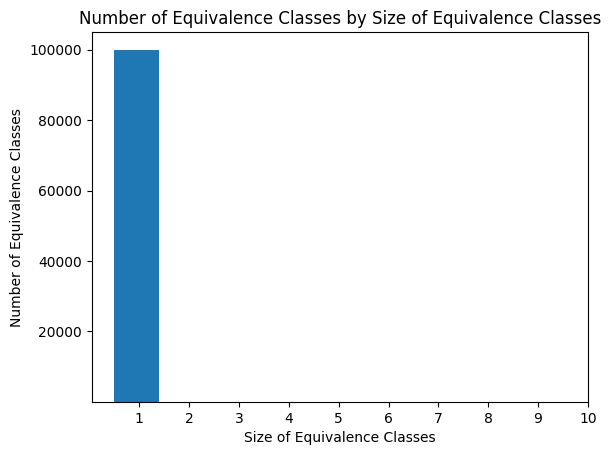

In [570]:
# Check the equivalence classes' sizes on all columns except for income and distance to work 
# (because they are sensitive information)
size_equivalence_classes(de_identified_dataset, ["postcode", "area", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])

We only have size 1 equivalence classes right now, which is really bad, but normal since we have modified almost nothing yet. We can still check the impact of the area and postcode on the k-anonymity.

[(1, 14166), (2, 3540), (3, 1453), (4, 881), (5, 610), (6, 486), (7, 368), (8, 314), (9, 488)]


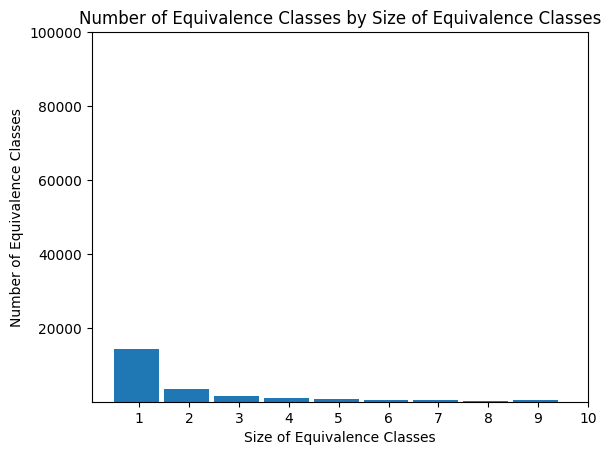

In [571]:
# Checking the size of the equivalence classes without considering the area and postcode columns
size_equivalence_classes(de_identified_dataset, ["age", "ethnic_group", "qualifications", "occupation", "home_ownership"])

This is much better as we go from 100 000 size-1 equivalence classes to 14 166 size-1 equivalence classes. So we can see that the area and postcode have a huge impact on the size of our equivalence classes.

[(4, 1), (17, 1), (64, 1), (97, 2), (98, 1)]


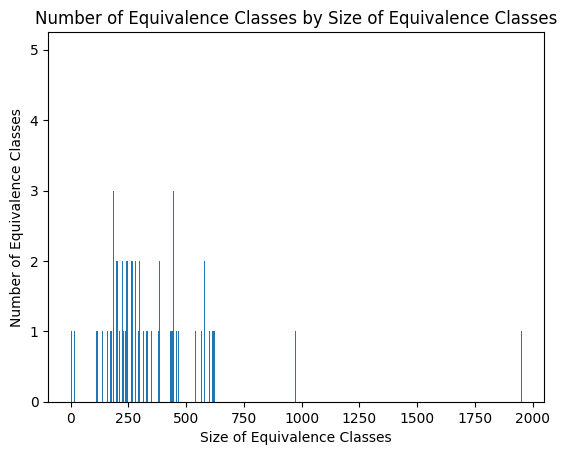

[(1, 99040), (2, 477), (3, 2)]


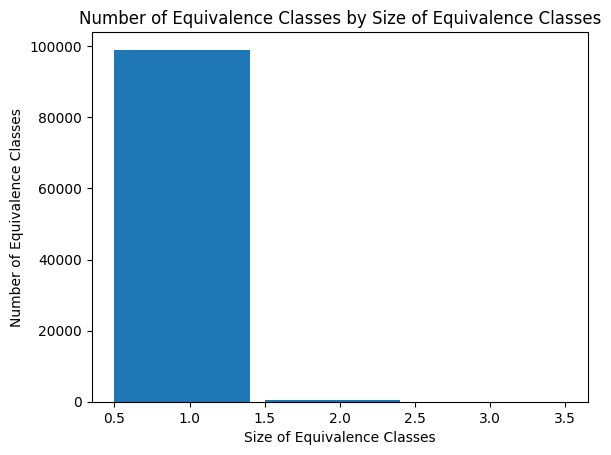

In [572]:
# Check what the equivalence classes look like for just the area and postcodes to check the distribution
size_equivalence_classes_all(de_identified_dataset, ["area"])
size_equivalence_classes_all(de_identified_dataset, ["postcode"])

We can see two issues here: the postcodes are much too precise and there is one equivalence class of size 4 and one of size 17 for the area, which is really little. This is a privacy issue as well because we don't want to release too accurate information on where people live. Since use case 2 only needs regions, we could simply generalize the postcodes and areas to regions, but we will first try to keep something more precise and only generalize to regions if our k-anonymity is still really bad. To do this, we will try non-perturbative methods: suppression and generalization.

We first remove the two equivalence classes of sizes 4 and 17 to see the impact this has.

In [573]:
# This function removes the equivalence classes of size k from the dataset
def remove_area_equivalence_classes(dataset, k):
  values = dataset.groupby("area").count()['postcode']
  drop_records_area = (values[values == k]).index[0]
  print("The area dropped is: ", drop_records_area)
  to_drop_rows = dataset[dataset['area'] == drop_records_area]
  new_dataset = dataset.drop(list(to_drop_rows.index), inplace=False)
  return new_dataset

# Remove the two equivalence classes of sizes 4 and 17
smaller_dataset = remove_area_equivalence_classes(de_identified_dataset, 4)
smaller_dataset = remove_area_equivalence_classes(smaller_dataset, 17)

The area dropped is:  Isles of Scilly
The area dropped is:  City of London


[(64, 1), (97, 2), (98, 1)]


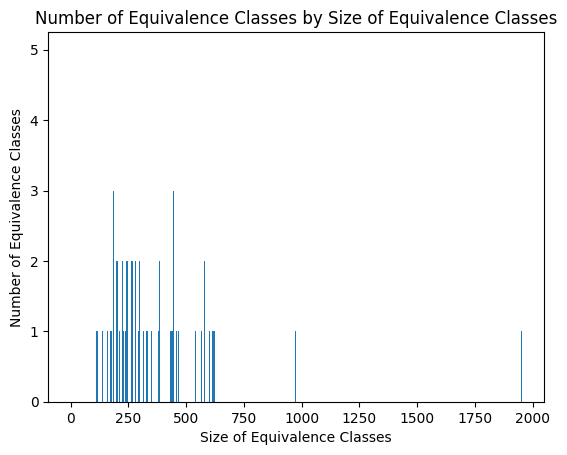

[(1, 99019), (2, 477), (3, 2)]


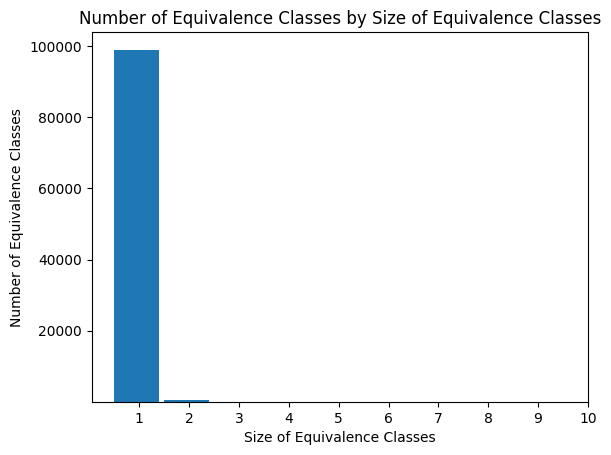

[(1, 99979)]


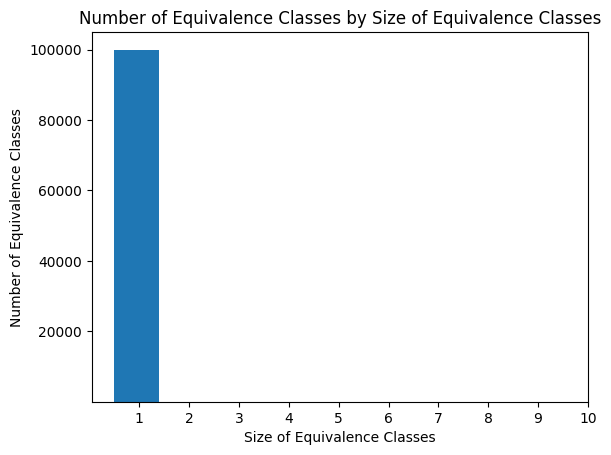

In [574]:
# Analyze the impact this has on the sizes of the equivalence classes
size_equivalence_classes_all(smaller_dataset, ["area"])
size_equivalence_classes(smaller_dataset, ["postcode"])
size_equivalence_classes(smaller_dataset, ["area", "postcode", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])

As expected, the postcode is still much too precise, so we will now try to generalize postcodes to outcodes.

In [575]:
# This function returns the outcode corresponding to the postcode
def postcode_to_outcode(postcode):
  return postcode.split()[0]

# Change the postcodes to outcodes in the DataFrame
smaller_dataset["postcode"] = smaller_dataset["postcode"].map(postcode_to_outcode)
smaller_dataset.rename(columns = {"postcode": "outcode"}, inplace=True)
smaller_dataset.head()

,area,outcode,gender,ethnic_group,marital_status,qualifications,occupation,income,home_ownership,distance_to_work_km,age
e778313316d4b62392301d68d189e0ae9306dd63f928328b11b6d48b13cd7564,Nottingham,NG9,Female,"White: English, Welsh, Scottish, Northern Iris...",married,Level 4 (BA+) or above,9. Elementary occupations,29445,1,4.593169,35
67e32dcd869504137977f070bf91401981bad741f729f4934ed145ef297a1a71,Shropshire,SY6,Female,"White: English, Welsh, Scottish, Northern Iris...",divorced,Level 4 (BA+) or above,"1. Managers, directors and senior officials",110432,1,0.000000,35
ad9255dfe0cff4ab2c72415a557db42eaea8923cbcb91ef67839aee84419b442,Wakefield,LS26,Female,White: Roma,never_married,Other,"8. Process, plant and machine operatives",22891,0,6.285012,42
1ee2dbbd23d513fa704951be71a85741152fd9ed96e10962270f8a29abfb5072,Tunbridge Wells,TN5,Female,"White: English, Welsh, Scottish, Northern Iris...",never_married,Level 1 (School),No occupation,4469,0,0.000000,17
c889f6af11fb25c2b8710789d30e6708e4bd6169538fcbc26ffc7e864bc173b3,Walsall,WS3,Male,"White: English, Welsh, Scottish, Northern Iris...",married,Level 1 (School),4. Administrative and secretarial occupations,26406,0,17.225231,74


[(2, 2), (3, 2), (4, 10), (5, 7), (6, 9), (7, 19), (8, 27), (9, 22), (10, 28), (11, 31), (12, 35), (13, 24), (14, 33), (15, 38), (16, 27), (17, 31), (18, 41), (19, 27), (20, 37), (21, 37), (22, 22), (23, 33), (24, 32), (25, 42), (26, 38), (27, 28), (28, 38), (29, 47), (30, 50), (31, 33), (32, 29), (33, 53), (34, 38), (35, 26), (36, 25), (37, 40), (38, 44), (39, 28), (40, 28), (41, 29), (42, 21), (43, 36), (44, 25), (45, 26), (46, 25), (47, 21), (48, 26), (49, 24), (50, 20), (51, 22), (52, 18), (53, 18), (54, 22), (55, 21), (56, 20), (57, 20), (58, 13), (59, 19), (60, 18), (61, 11), (62, 20), (63, 17), (64, 20), (65, 16), (66, 20), (67, 22), (68, 11), (69, 8), (70, 20), (71, 19), (72, 18), (73, 15), (74, 20), (75, 10), (76, 14), (77, 15), (78, 10), (79, 10), (80, 16), (81, 7), (82, 8), (83, 12), (84, 8), (85, 9), (86, 6), (87, 11), (88, 6), (89, 6), (90, 3), (91, 4), (92, 6), (93, 2), (94, 6), (95, 7), (96, 5), (97, 8), (98, 5), (99, 4), (100, 9)]


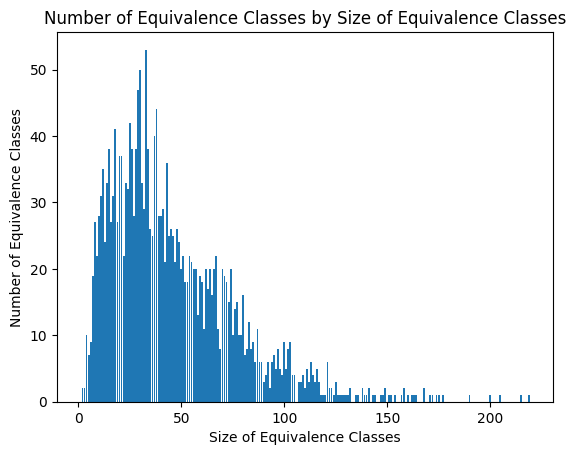

[(1, 98586), (2, 659), (3, 21), (4, 3)]


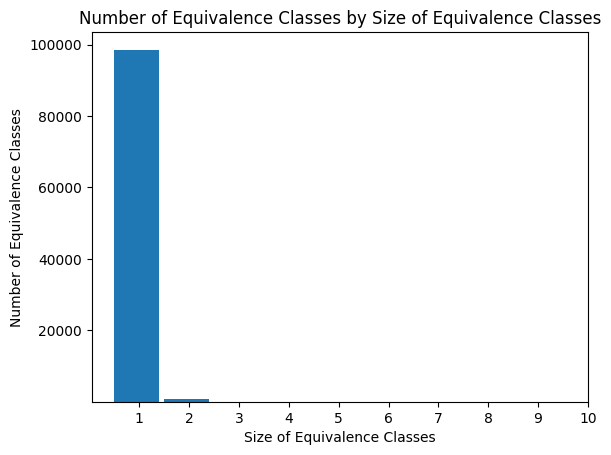

In [576]:
# Plot the equivalence classes again
size_equivalence_classes_all(smaller_dataset, ["outcode"])
size_equivalence_classes(smaller_dataset, ["area", "outcode", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])

These numbers are still not good enough since we have 98 586 size-1 equivalence classes. The next step in generalization is to generalize the "area" and "outcodes" to just "area".

[(1, 88446), (2, 4114), (3, 596), (4, 176), (5, 67), (6, 31), (7, 17), (8, 1), (9, 7)]


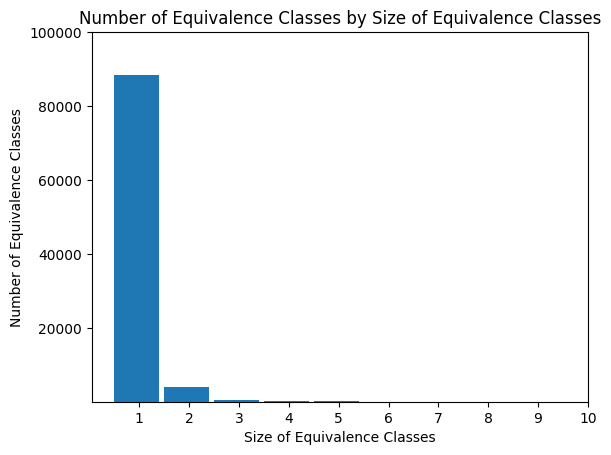

,area,gender,ethnic_group,marital_status,qualifications,occupation,income,home_ownership,distance_to_work_km,age
e778313316d4b62392301d68d189e0ae9306dd63f928328b11b6d48b13cd7564,Nottingham,Female,"White: English, Welsh, Scottish, Northern Iris...",married,Level 4 (BA+) or above,9. Elementary occupations,29445,1,4.593169,35
67e32dcd869504137977f070bf91401981bad741f729f4934ed145ef297a1a71,Shropshire,Female,"White: English, Welsh, Scottish, Northern Iris...",divorced,Level 4 (BA+) or above,"1. Managers, directors and senior officials",110432,1,0.000000,35
ad9255dfe0cff4ab2c72415a557db42eaea8923cbcb91ef67839aee84419b442,Wakefield,Female,White: Roma,never_married,Other,"8. Process, plant and machine operatives",22891,0,6.285012,42
1ee2dbbd23d513fa704951be71a85741152fd9ed96e10962270f8a29abfb5072,Tunbridge Wells,Female,"White: English, Welsh, Scottish, Northern Iris...",never_married,Level 1 (School),No occupation,4469,0,0.000000,17
c889f6af11fb25c2b8710789d30e6708e4bd6169538fcbc26ffc7e864bc173b3,Walsall,Male,"White: English, Welsh, Scottish, Northern Iris...",married,Level 1 (School),4. Administrative and secretarial occupations,26406,0,17.225231,74


In [577]:
# Drop the outcodes from the dataset and check the equivalence classes again
smaller_dataset.drop("outcode", axis=1, inplace=True)
size_equivalence_classes(smaller_dataset, ["area", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
smaller_dataset.head()

This is still not as good as we would want it to be. So we will now try to generalize further to replace the areas by their corresponding regions. To do this, we need to get back to the version with the postcodes. So the records from the sizes 4 and 17 for the area are back in the dataset, which is best since they might not be an issue anymore as we are generalizing to regions.

In [578]:
# Get a mapping to map the areas to the regions
def get_region(postcode_area):
  return area_code_to_region[postcode_area]

# Define a function to get the area code from the postcodes
def get_postcode_info(postcode):
  postcode_info = ukpostcode.parse(postcode)
  return postcode_info.area

# Replace the postcode column by a region column and drop the area column
de_identified_dataset['area_code'] = de_identified_dataset['postcode'].map(get_postcode_info)
de_identified_dataset['region'] = de_identified_dataset['area_code'].map(get_region)
de_identified_dataset.drop(['postcode', 'area_code', 'area'], axis=1, inplace=True)
de_identified_dataset.head()

,gender,ethnic_group,marital_status,qualifications,occupation,income,home_ownership,distance_to_work_km,age,region
e778313316d4b62392301d68d189e0ae9306dd63f928328b11b6d48b13cd7564,Female,"White: English, Welsh, Scottish, Northern Iris...",married,Level 4 (BA+) or above,9. Elementary occupations,29445,1,4.593169,35,East Midlands
67e32dcd869504137977f070bf91401981bad741f729f4934ed145ef297a1a71,Female,"White: English, Welsh, Scottish, Northern Iris...",divorced,Level 4 (BA+) or above,"1. Managers, directors and senior officials",110432,1,0.000000,35,Wales
ad9255dfe0cff4ab2c72415a557db42eaea8923cbcb91ef67839aee84419b442,Female,White: Roma,never_married,Other,"8. Process, plant and machine operatives",22891,0,6.285012,42,North East
1ee2dbbd23d513fa704951be71a85741152fd9ed96e10962270f8a29abfb5072,Female,"White: English, Welsh, Scottish, Northern Iris...",never_married,Level 1 (School),No occupation,4469,0,0.000000,17,South East
c889f6af11fb25c2b8710789d30e6708e4bd6169538fcbc26ffc7e864bc173b3,Male,"White: English, Welsh, Scottish, Northern Iris...",married,Level 1 (School),4. Administrative and secretarial occupations,26406,0,17.225231,74,West Midlands


[(1, 38081), (2, 7910), (3, 3514), (4, 1791), (5, 1026), (6, 645), (7, 427), (8, 289), (9, 324)]


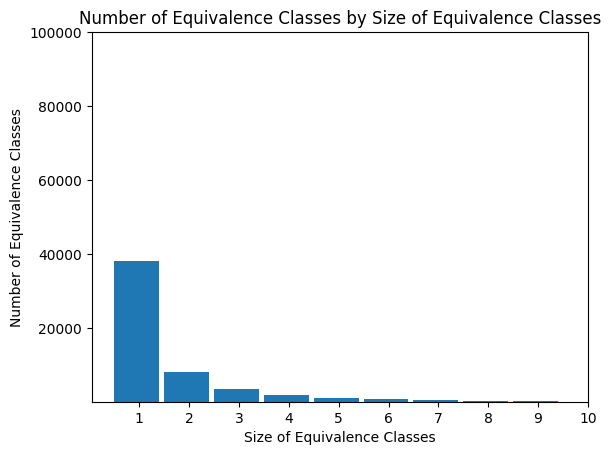

region
East England        1743
East Midlands      10043
East of England     7929
Greater London     18090
North East          8945
North West         15451
Scotland              96
South East         13986
South West          8167
Wales               5668
West Midlands       9882
dtype: int64

In [579]:
# We can check the equivalence classes again
size_equivalence_classes(de_identified_dataset, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])

# We can check how many people there are in each region as well, to notice any disparities
de_identified_dataset.groupby(["region"]).size()

We finally see a real improvement as the number of size-1 equivalence classes drops to 38 081. However, we can notice disparities in the table since there are only 96 people from Scotland, which is really little compared to other regions. We might want to use suppression to remove these 96 records, but we will wait until after generalizing the other quasi-identifiers to see whether deleting these records has a beneficial enough impact.

## 3.2) Age

[(1, 38081), (2, 7910), (3, 3514), (4, 1791), (5, 1026), (6, 645), (7, 427), (8, 289), (9, 324)]


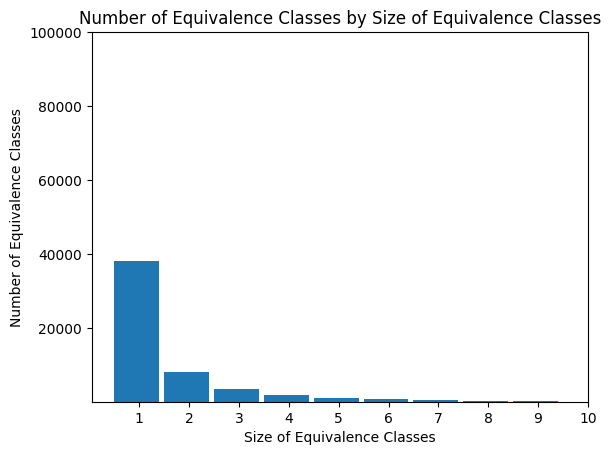

[(1, 3834), (2, 1624), (3, 883), (4, 516), (5, 371), (6, 268), (7, 198), (8, 144), (9, 231)]


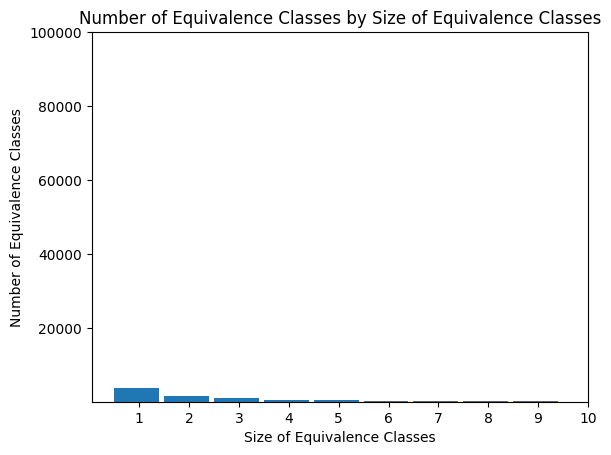

In [580]:
size_equivalence_classes(de_identified_dataset, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
size_equivalence_classes(de_identified_dataset, ["region", "ethnic_group", "qualifications", "occupation", "home_ownership"])

As expected, the age has a significant impact on the size of the equivalence classes. However, we cannot generalize the age too much, as otherwise, this will impede utility. Since use case 3 compares the distance to work to the age, having small logical age ranges seems reasonable (for instance, since most people over 65 do not work anymore and thus do not have a distance to work, it seems reasonable to group them in a "over 65" range). We will use entropy to compare the loss of information for different generalisations.

In [581]:
# The function maps an age to its corresponding age range
## The age ranges are: 16-25, 25-40, 40-50, 50-65, 65+
def age_to_range1(age):
    if age >= 65:
        return '65+'
    elif age >= 50:
        return '50-65'
    elif age >= 40:
        return '40-50'
    elif age >= 25:
        return '25-40'
    else:
        return '16-25'

# The function maps an age to its corresponding age range
## The age ranges are: 16-25, 25-35, 35-45, 45-55, 55-65, 65+
def age_to_range2(age):
    if age >= 65:
        return '65+'
    elif age >= 55:
        return '55-65'
    elif age >= 45:
        return '45-55'
    elif age >= 35:
        return '35-45'
    elif age >= 25:
        return '25-35'
    else:
        return '16-25'

# The function maps an age to its corresponding age range
## The age ranges are: 16-20, 20-30, 30-40, 40-50, 50-60, 60-70, 70+
def age_to_range3(age):
    if age >= 70:
        return '70+'
    elif age >= 60:
        return '60-70'
    elif age >= 50:
        return '50-60'
    elif age >= 40:
        return '40-50'
    elif age >= 30:
        return '30-40'
    elif age >= 20:
        return '20-30'
    else:
        return '16-20'

# The function maps an age to its corresponding age range
## The age ranges are: 16-20, 20-25, 25-30, 30-35, 35-40, 40-45,
## 45-50, 50-55, 55-60, 60-65, 65-70, 70-75, 75+
def age_to_range4(age):
    if age >= 75:
        return '75+'
    elif age >= 70:
        return '70-75'
    elif age >= 65:
        return '65-70'
    elif age >= 60:
        return '60-65'
    elif age >= 55:
        return '55-60'
    elif age >= 50:
        return '50-55'
    elif age >= 45:
        return '45-50'
    elif age >= 40:
        return '40-45'
    elif age >= 35:
        return '35-40'
    elif age >= 30:
        return '30-35'
    elif age >= 25:
        return '25-30'
    elif age >= 20:
        return '20-25'
    else:
        return '16-20'

In [582]:
de_identified_dataset.groupby(["age"]).size()

age
16    1137
17    1418
18    1360
19    1426
20    1443
      ... 
87     372
88     353
89     278
90     907
91     225
Length: 76, dtype: int64

In [583]:
gen_dataset1 = de_identified_dataset.copy()
gen_dataset1["age"] = de_identified_dataset["age"].map(age_to_range1)
gen_dataset1.groupby(["age"]).size()

age
16-25    12737
25-40    24969
40-50    15399
50-65    23660
65+      23235
dtype: int64

In [584]:
gen_dataset2 = de_identified_dataset.copy()
gen_dataset2["age"] = de_identified_dataset["age"].map(age_to_range2)
gen_dataset2.groupby(["age"]).size()

age
16-25    12737
25-35    16714
35-45    15989
45-55    16025
55-65    15300
65+      23235
dtype: int64

In [585]:
gen_dataset3 = de_identified_dataset.copy()
gen_dataset3["age"] = de_identified_dataset["age"].map(age_to_range3)
gen_dataset3.groupby(["age"]).size()

age
16-20     5341
20-30    15465
30-40    16900
40-50    15399
50-60    16500
60-70    13318
70+      17077
dtype: int64

In [586]:
gen_dataset4 = de_identified_dataset.copy()
gen_dataset4["age"] = de_identified_dataset["age"].map(age_to_range4)
gen_dataset4.groupby(["age"]).size()

age
16-20     5341
20-25     7396
25-30     8069
30-35     8645
35-40     8255
40-45     7734
45-50     7665
50-55     8360
55-60     8140
60-65     7160
65-70     6158
70-75     6252
75+      10825
dtype: int64

[(1, 38081), (2, 7910), (3, 3514), (4, 1791), (5, 1026), (6, 645), (7, 427), (8, 289), (9, 324)]


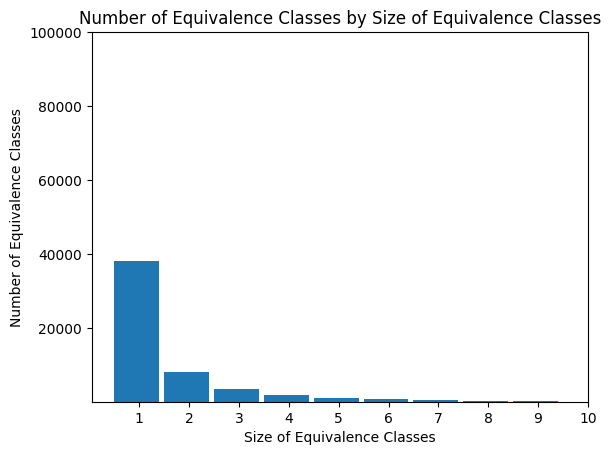

[(1, 11190), (2, 3084), (3, 1336), (4, 762), (5, 502), (6, 370), (7, 306), (8, 249), (9, 376)]


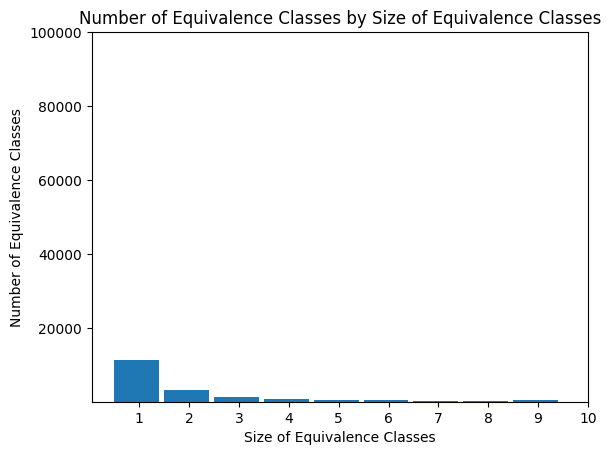

[(1, 12435), (2, 3323), (3, 1373), (4, 785), (5, 562), (6, 425), (7, 346), (8, 259), (9, 425)]


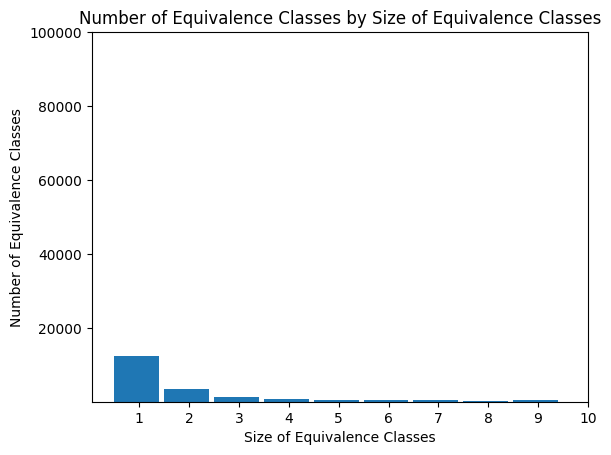

[(1, 13001), (2, 3493), (3, 1413), (4, 835), (5, 546), (6, 407), (7, 288), (8, 315), (9, 417)]


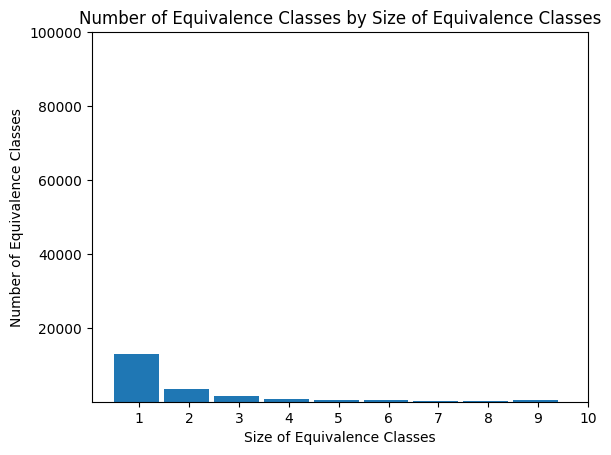

[(1, 17978), (2, 4080), (3, 1837), (4, 1086), (5, 801), (6, 670), (7, 462), (8, 377), (9, 513)]


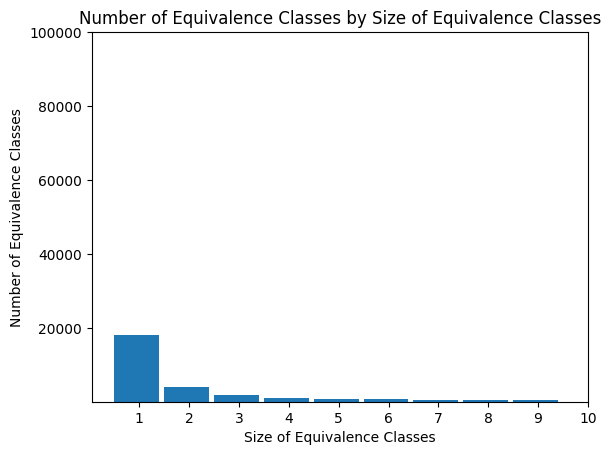

In [587]:
# Consider the impact on the size of the equivalence classes
size_equivalence_classes(de_identified_dataset, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
size_equivalence_classes(gen_dataset1, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
size_equivalence_classes(gen_dataset2, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
size_equivalence_classes(gen_dataset3, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
size_equivalence_classes(gen_dataset4, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])

In [588]:
# Compare the loss of information (using entropy)
entropy_original = entropy(de_identified_dataset, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
entropy_gen1 = entropy(gen_dataset1, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
entropy_gen2 = entropy(gen_dataset2, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
entropy_gen3 = entropy(gen_dataset3, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
entropy_gen4 = entropy(gen_dataset4, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])

print("Loss of information for the first generalised dataset: ", round(100 - entropy_gen1 / entropy_original * 100, 2), "%")
print("Loss of information for the second generalised dataset: ", round(100 - entropy_gen2 / entropy_original * 100, 2), "%")
print("Loss of information for the third generalised dataset: ", round(100 - entropy_gen3 / entropy_original * 100, 2), "%")
print("Loss of information for the fourth generalised dataset: ", round(100 - entropy_gen4 / entropy_original * 100, 2), "%")

Loss of information for the first generalised dataset:  17.46 %
Loss of information for the second generalised dataset:  15.9 %
Loss of information for the third generalised dataset:  15.03 %
Loss of information for the fourth generalised dataset:  10.33 %


The loss of information is really high for these ranges. For the first age ranges, we lose 17.46% of the information by generalising, which is too much. However, for the last age ranges, we only lose 10.33% of information but there are 17 987 size-1 equivalence classes. We chose the third generalisation ranges, since they seem to be the most appropriate here.

In [589]:
de_identified_dataset["age"] = gen_dataset3["age"]

## 3.3) Ethnicity

[(1, 13001), (2, 3493), (3, 1413), (4, 835), (5, 546), (6, 407), (7, 288), (8, 315), (9, 417)]


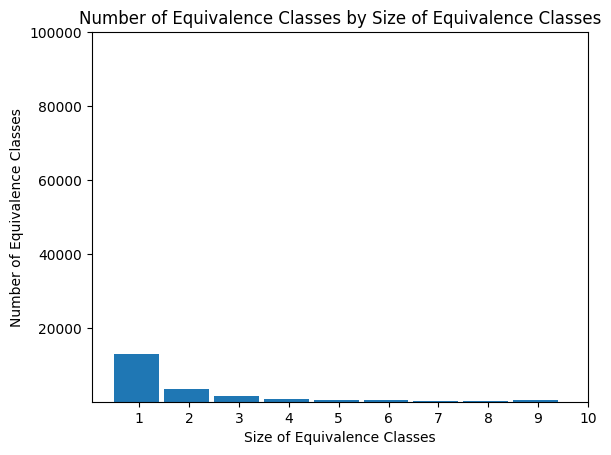

[(1, 961), (2, 638), (3, 509), (4, 384), (5, 312), (6, 279), (7, 258), (8, 226), (9, 418)]


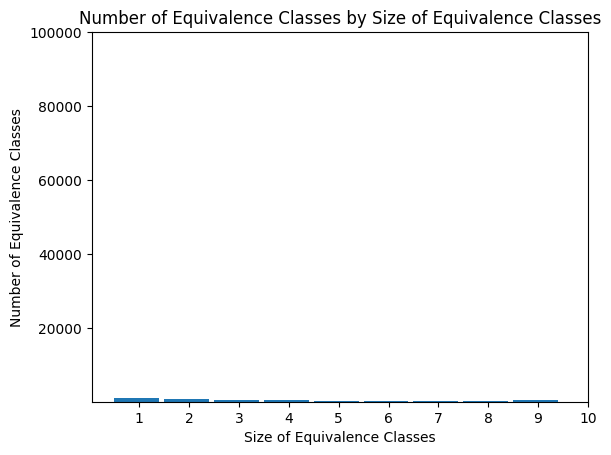

ethnic_group
Asian, Asian British or Asian Welsh: Bangladeshi                           1113
Asian, Asian British or Asian Welsh: Chinese                                717
Asian, Asian British or Asian Welsh: Indian                                3175
Asian, Asian British or Asian Welsh: Other Asian                           1678
Asian, Asian British or Asian Welsh: Pakistani                             2671
Black, Black British, Black Welsh, Caribbean or African: African           2568
Black, Black British, Black Welsh, Caribbean or African: Caribbean         1041
Black, Black British, Black Welsh, Caribbean or African: Other Black        513
Mixed or Multiple ethnic groups: Other Mixed or Multiple ethnic groups      785
Mixed or Multiple ethnic groups: White and Asian                            809
Mixed or Multiple ethnic groups: White and Black African                    402
Mixed or Multiple ethnic groups: White and Black Caribbean                  860
Other ethnic group: Any oth

In [590]:
size_equivalence_classes(de_identified_dataset, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
size_equivalence_classes(de_identified_dataset, ["region", "age", "qualifications", "occupation", "home_ownership"])
de_identified_dataset.groupby(["ethnic_group"]).size()

We can notice important disparities here since the ethnic group "White: English, Welsh, Scottish, Northern Irish or British" has 74 201 records whereas the other ethnic groups have at most 6 202 records. We can also notice that the ethnic group has a significant impact on the size of the equivalence classes. The reasonable option for generalisation here would be to categorise the ethnic groups in larger ethnic groups and to optionally have a separate group for "White: English, Welsh, Scottish, Northern Irish or British".

In [591]:
# Function to generalise ethnic groups into larger ethnic groups (keep only the part before ':')
def generalise_ethnic_group1(ethnic_group):
  return ethnic_group.split(":")[0]

# Generalised dataset with larger ethnic groups
gen_dataset1 = de_identified_dataset.copy()
gen_dataset1["ethnic_group"] = de_identified_dataset["ethnic_group"].map(generalise_ethnic_group1)
gen_dataset1.groupby(["ethnic_group"]).size()

ethnic_group
Asian, Asian British or Asian Welsh                         9354
Black, Black British, Black Welsh, Caribbean or African     4122
Mixed or Multiple ethnic groups                             2856
Other ethnic group                                          2127
White                                                      81541
dtype: int64

In [592]:
# Function to generalise ethnic groups into larger ethnic groups (keep only the part before ':')
# and keep "White: English, Welsh, Scottish, Northern Irish or British" as a separate ethnic group
def generalise_ethnic_group2(ethnic_group):
  if ethnic_group == "White: English, Welsh, Scottish, Northern Irish or British":
    return ethnic_group
  else:
    generalised = ethnic_group.split(":")[0]
    if generalised == "White":
      return "White: Other White"
    else:
      return generalised

# Generalised dataset with larger ethnic groups and "White: English, Welsh..." separate
gen_dataset2 = de_identified_dataset.copy()
gen_dataset2["ethnic_group"] = de_identified_dataset["ethnic_group"].map(generalise_ethnic_group2)
gen_dataset2.groupby(["ethnic_group"]).size()

ethnic_group
Asian, Asian British or Asian Welsh                            9354
Black, Black British, Black Welsh, Caribbean or African        4122
Mixed or Multiple ethnic groups                                2856
Other ethnic group                                             2127
White: English, Welsh, Scottish, Northern Irish or British    74201
White: Other White                                             7340
dtype: int64

We can now compare the different generalisations by considering the improvement on the size of the equivalence classes and the loss of information (using entropy).

[(1, 13001), (2, 3493), (3, 1413), (4, 835), (5, 546), (6, 407), (7, 288), (8, 315), (9, 417)]


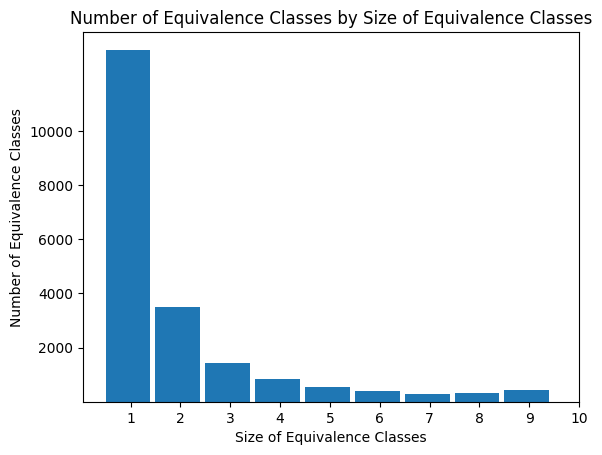

[(1, 5862), (2, 2464), (3, 1277), (4, 790), (5, 603), (6, 413), (7, 370), (8, 303), (9, 487)]


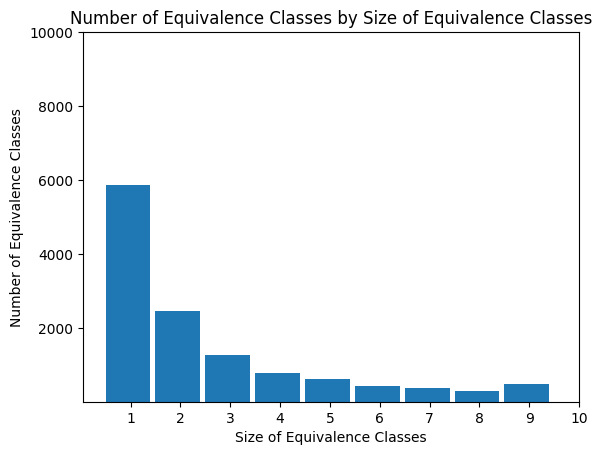

[(1, 7400), (2, 3112), (3, 1571), (4, 975), (5, 716), (6, 498), (7, 393), (8, 360), (9, 498)]


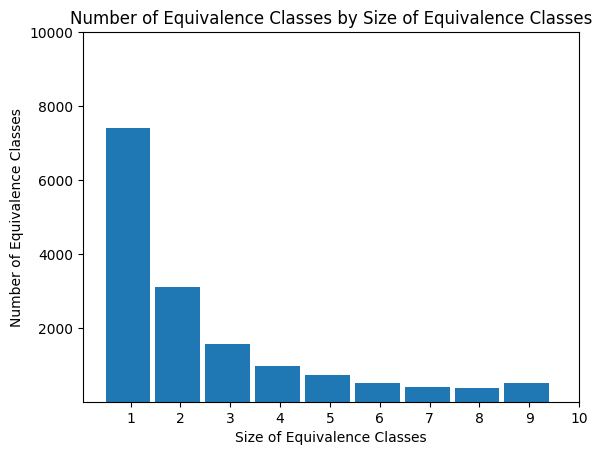

In [593]:
# Compare the impact on the size of the equivalence classes
size_equivalence_classes_small(de_identified_dataset, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
size_equivalence_classes_small(gen_dataset1, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
size_equivalence_classes_small(gen_dataset2, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])

In [594]:
# Compare the loss of information (using entropy)
entropy_original = entropy(de_identified_dataset, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
entropy_gen1 = entropy(gen_dataset1, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
entropy_gen2 = entropy(gen_dataset2, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])

print("Loss of information for the first generalised dataset: ", round(100 - entropy_gen1 / entropy_original * 100, 2), "%")
print("Loss of information for the second generalised dataset: ", round(100 - entropy_gen2 / entropy_original * 100, 2), "%")

Loss of information for the first generalised dataset:  3.88 %
Loss of information for the second generalised dataset:  1.46 %


The loss of information here is really low, which is good, it means we do not lose to much information. Also, the size of the equivalence classes do not change by much from one generalisation to the other. From a utility point of view, since the use case is to study pay inequity between different racial groups, it seems important to make a difference between the ethnic group "White: English, Welsh, Scottish, Northern Irish or British" and the other ethnic groups since from the regions, we can see it mostly concerns people working in the UK.

In [595]:
de_identified_dataset["ethnic_group"] = gen_dataset1["ethnic_group"]

## 3.4) Qualifications

[(1, 5862), (2, 2464), (3, 1277), (4, 790), (5, 603), (6, 413), (7, 370), (8, 303), (9, 487)]


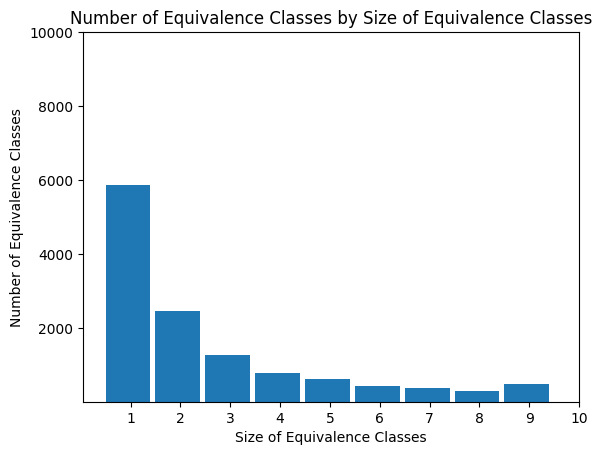

[(1, 1109), (2, 699), (3, 485), (4, 359), (5, 251), (6, 187), (7, 169), (8, 131), (9, 194)]


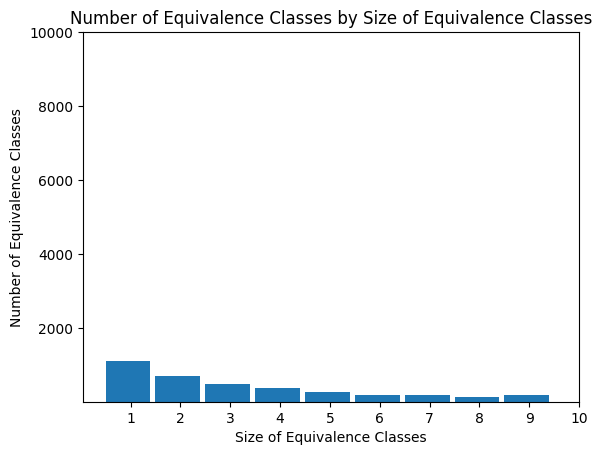

qualifications
Apprenticeship             6565
Level 1 (School)          13712
Level 2 (School)          18826
Level 3 (High school)     20876
Level 4 (BA+) or above    37042
Other                      2979
dtype: int64

In [596]:
size_equivalence_classes_small(de_identified_dataset, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
size_equivalence_classes_small(de_identified_dataset, ["region", "age", "ethnic_group", "occupation", "home_ownership"])
de_identified_dataset.groupby(["qualifications"]).size()

We can see that the qualifications attribute also has an impact on the size of the equivalence classes. And the obvious mapping, which doesn't impede utility in the least would be to generalise Levels 1 through 3 of School to "Level 1-3 (School)" since it corresponds to the same qualifications.

[(1, 3689), (2, 1759), (3, 1027), (4, 657), (5, 483), (6, 336), (7, 243), (8, 191), (9, 277)]


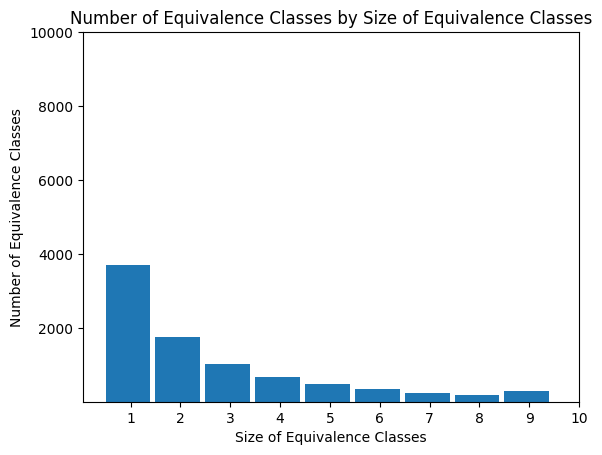

qualifications
Apprenticeship             6565
Level 1-3 (School)        53414
Level 4 (BA+) or above    37042
Other                      2979
dtype: int64

In [597]:
# This seems to be the obvious mapping, which impedes utility in the least
qualifications_generalisation = {
    'Level 4 (BA+) or above': 'Level 4 (BA+) or above',
    'Level 3 (High school)': 'Level 1-3 (School)',
    'Level 2 (School)': 'Level 1-3 (School)',
    'Level 1 (School)': 'Level 1-3 (School)',
    'Apprenticeship': 'Apprenticeship',
    'Other': 'Other'
}

# Generalise the dataset
gen_dataset = de_identified_dataset.copy()
gen_dataset['qualifications'] = de_identified_dataset['qualifications'].map(qualifications_generalisation)
size_equivalence_classes_small(gen_dataset, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
gen_dataset.groupby(["qualifications"]).size()

In [598]:
# Compare the loss of information (using entropy)
entropy_original = entropy(de_identified_dataset, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
entropy_gen = entropy(gen_dataset, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
print("Loss of information for the generalised dataset: ", round(100 - entropy_gen / entropy_original * 100, 2), "%")

Loss of information for the generalised dataset:  5.57 %


This confirms that almost no information is lost.

In [599]:
de_identified_dataset["qualifications"] = gen_dataset["qualifications"]

## 3.5) Occupation

We tried to group the occupations in a way that would affect utility in the least, considering the fact that this attribute would be used to identify pay inequities.

In [600]:
de_identified_dataset.groupby(["occupation"]).size()

occupation
1. Managers, directors and senior officials            10603
2. Professional occupations                            17037
3. Associate professional and technical occupations    11000
4. Administrative and secretarial occupations           7831
5. Skilled trades occupations                           8793
6. Caring, leisure and other service occupations        7941
7. Sales and customer service occupations               6493
8. Process, plant and machine operatives                6056
9. Elementary occupations                               8887
No occupation                                          15359
dtype: int64

In [601]:
occupation_generalisation = {
    '2. Professional occupations': 'Management and Professional Occupations',
    '3. Associate professional and technical occupations': 'Management and Professional Occupations',
    '1. Managers, directors and senior officials': 'Management and Professional Occupations',
    '4. Administrative and secretarial occupations': 'Administrative and Support Occupations',
    '7. Sales and customer service occupations': 'Administrative and Support Occupations',
    '5. Skilled trades occupations': 'Skilled and Technical Occupations',
    '8. Process, plant and machine operatives': 'Skilled and Technical Occupations',
    '6. Caring, leisure and other service occupations': 'Service and Care Occupations',
    '9. Elementary occupations': 'Service and Care Occupations',
    'No occupation': 'Unemployed'
}

# Generalise the dataset
gen_dataset = de_identified_dataset.copy()
gen_dataset['occupation'] = de_identified_dataset['occupation'].map(occupation_generalisation)
gen_dataset.groupby(["occupation"]).size()

occupation
Administrative and Support Occupations     14324
Management and Professional Occupations    38640
Service and Care Occupations               16828
Skilled and Technical Occupations          14849
Unemployed                                 15359
dtype: int64

[(1, 1876), (2, 1009), (3, 662), (4, 465), (5, 303), (6, 230), (7, 187), (8, 151), (9, 251)]


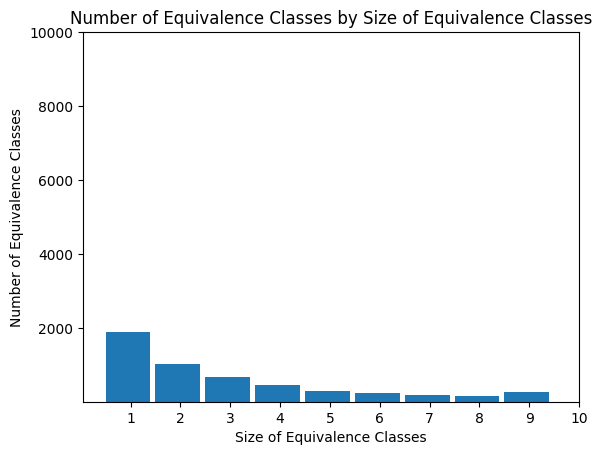

Loss of information for the generalised dataset:  8.35 %


In [602]:
# Consider the impact on the size of the equivalence classes
size_equivalence_classes_small(gen_dataset, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])

# Consider the loss of information
entropy_original = entropy(de_identified_dataset, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
entropy_gen = entropy(gen_dataset, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
print("Loss of information for the generalised dataset: ", round(100 - entropy_gen / entropy_original * 100, 2), "%")

In [603]:
de_identified_dataset["occupation"] = gen_dataset["occupation"]

## 3.6) Suppression

### 3.6.1) Marital status

[(1, 1876), (2, 1009), (3, 662), (4, 465), (5, 303), (6, 230), (7, 187), (8, 151), (9, 251)]


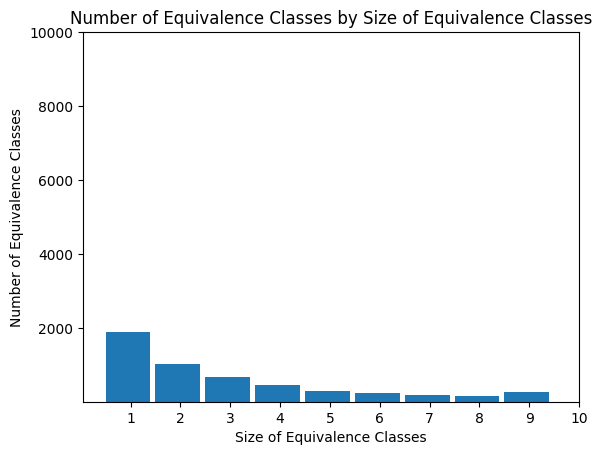

[(1, 5755), (2, 2314), (3, 1218), (4, 729), (5, 518), (6, 428), (7, 297), (8, 234), (9, 354)]


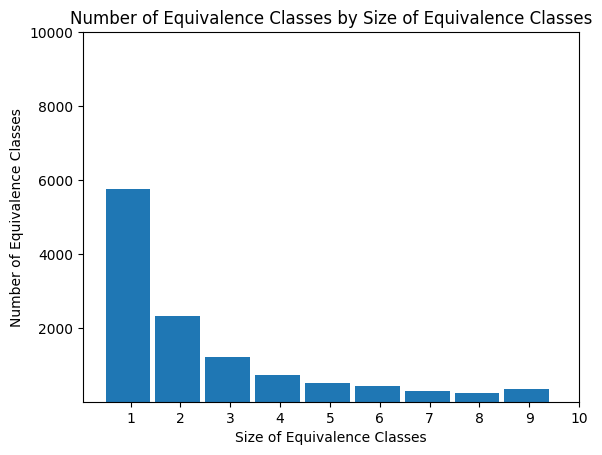

In [604]:
size_equivalence_classes_small(de_identified_dataset, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
size_equivalence_classes_small(de_identified_dataset, ["region", "age", "ethnic_group", "qualifications", "occupation", "marital_status", "home_ownership"])

Since the marital status has no utility and it affects k-anonymity, we choose to remove this attribute.

In [605]:
de_identified_dataset.drop("marital_status", axis=1, inplace=True)

### 3.6.2) Gender

[(1, 1876), (2, 1009), (3, 662), (4, 465), (5, 303), (6, 230), (7, 187), (8, 151), (9, 251)]


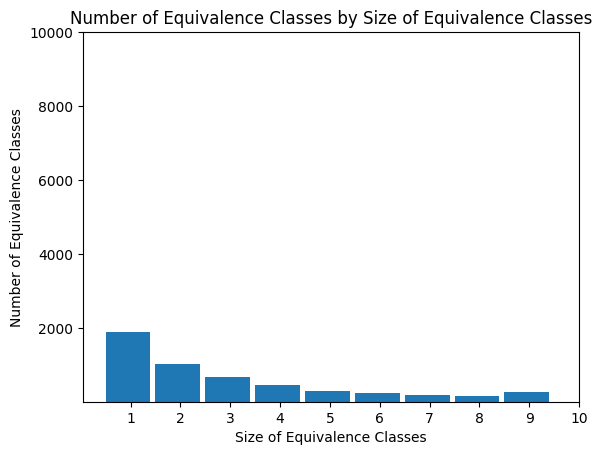

[(1, 4252), (2, 1805), (3, 1041), (4, 688), (5, 424), (6, 286), (7, 279), (8, 177), (9, 240)]


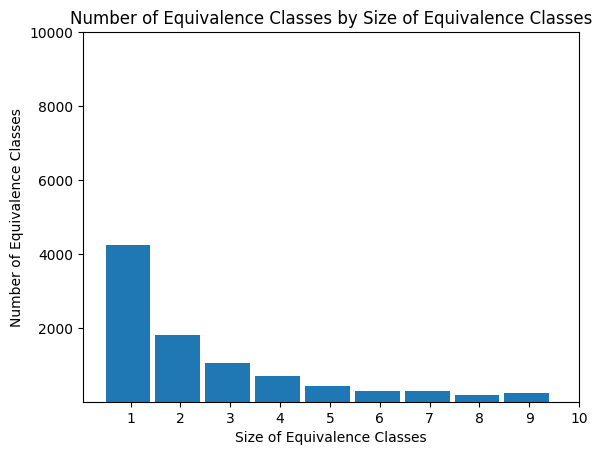

In [606]:
size_equivalence_classes_small(de_identified_dataset, ["region", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
size_equivalence_classes_small(de_identified_dataset, ["region", "age", "ethnic_group", "qualifications", "occupation", "gender", "home_ownership"])

For the gender attribute, we choose to keep it because we consider it really important for use case 1 even though it affects the size of the equivalence classes.

### 3.6.2) Record supression

In [607]:
# Function, which computes and returns the number of records to delete from
# 'dataset' to achieve k-anonymity (considering 'cols' as the quasi-identifiers)
def nb_to_remove(k, dataset, cols):
    lengths = dataset.groupby(cols).size().values.tolist()
    remove = 0
    for length in lengths:
        if length < k:
            remove += length
    return remove


# Function, which returns the a list of indexes of the records to remove
# from the dataset to obtain k-anonymity
def to_be_removed(k, dataset, cols):
    result = []
    groups = dataset.groupby(cols)
    for group, idxs in groups:
        if len(idxs) < k:
            result += idxs.index.tolist()
    return result


# Function, which returns a new dataset, which went through suppression
# to become k-anonymous
def remove_rows(k, dataset, cols):
    result = dataset.copy()
    to_remove = to_be_removed(k, dataset, cols)
    result.drop(to_remove, inplace=True)
    return result

In [608]:
for k in range(2, 5):
    n = nb_to_remove(k, de_identified_dataset, ["region", "gender", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
    print(f"To get {k}-anonymity, we would need to remove {n} records")

To get 2-anonymity, we would need to remove 4252 records
To get 3-anonymity, we would need to remove 7862 records
To get 4-anonymity, we would need to remove 10985 records


We would need to delete 10 985 records to obtain a 4-anonymous dataset.

In [609]:
original_entropy = entropy(de_identified_dataset, ["region", "gender", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
for i in range(2, 11):
    i_anonymous_dataset = remove_rows(i, de_identified_dataset, ["region", "gender", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
    n = nb_to_remove(i, de_identified_dataset, ["region", "gender", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
    i_anonymous_entropy = entropy(i_anonymous_dataset, ["region", "gender", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
    print(f"For a {i}-anonymous dataset: loss of information {round(100 - i_anonymous_entropy/original_entropy * 100, 2)}%, {n} records removed ({round(n / 1000, 2)}%)")

For a 2-anonymous dataset: loss of information 2.4%, 4252 records removed (4.25%)
For a 3-anonymous dataset: loss of information 4.26%, 7862 records removed (7.86%)
For a 4-anonymous dataset: loss of information 5.79%, 10985 records removed (10.98%)
For a 5-anonymous dataset: loss of information 7.11%, 13737 records removed (13.74%)
For a 6-anonymous dataset: loss of information 8.11%, 15857 records removed (15.86%)
For a 7-anonymous dataset: loss of information 8.9%, 17573 records removed (17.57%)
For a 8-anonymous dataset: loss of information 9.79%, 19526 records removed (19.53%)
For a 9-anonymous dataset: loss of information 10.43%, 20942 records removed (20.94%)
For a 10-anonymous dataset: loss of information 10.94%, 22085 records removed (22.09%)


We pick $k=4$ as we only lose around 5.79% of the information and only delete 10.98% of the records.

[(4, 688), (5, 424), (6, 286), (7, 279), (8, 177), (9, 240)]


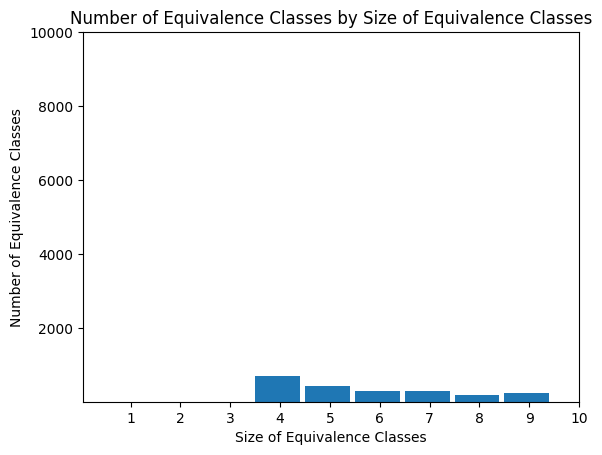

In [610]:
de_identified_dataset = remove_rows(4, de_identified_dataset, ["region", "gender", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])
size_equivalence_classes_small(de_identified_dataset, ["region", "gender", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"])

# 4) l-diversity

We will now consider the sensitive attributes. We would like the dataset to be at least 2-diverse for every sensitive attribute.

In [611]:
# Function, which returns True if the dataset is at least l-diverse for the
# sensitive attribute given as parameter and considering 'columns' as the
# columns of the quasi-identifiers
def l_diversity(dataset, columns, sensitive_attribute, l):
    groups = dataset.groupby(columns)
    for group, data in groups:
        distinct_values = data[sensitive_attribute].nunique()
        if distinct_values < l:
            return False
    return True


# Function, which returns a new dataset in which records have been removed
# to obtain l-diversity
def remove_rows_l_diverse(dataset, columns, sensitive_attribute, l):
    result = dataset.copy()
    groups = dataset.groupby(columns)
    indices_to_drop = []
    for _, group_data in groups:
        distinct_sensitive_values = group_data[sensitive_attribute].nunique()
        if distinct_sensitive_values < l:
            indices_to_drop.extend(group_data.index.tolist())
    result.drop(indices_to_drop, inplace=True)
    return result


# Function, which returns the number of records to delete to obtain l-diversity
def nb_to_remove_l_diverse(dataset, columns, sensitive_attribute, l):
    remove_count = 0
    groups = dataset.groupby(columns)
    for _, group_data in groups:
        distinct_sensitive_values = group_data[sensitive_attribute].nunique()
        if distinct_sensitive_values < l:
            remove_count += len(group_data)
    return remove_count

# Function, which prints the loss of information and number of records to remove to
# obtain l-diversity on the dataset for l = 2, 3, 4, 5
def compare_l_diversities(dataset, columns, sensitive_attribute):
    original_entropy = entropy(dataset, columns)
    for l in range(2, 6):
        if l_diversity(dataset, columns, sensitive_attribute, l):
            print(f"{l}-diversity: the dataset is already {l}-diverse for {sensitive_attribute}")
        else:
            l_diverse_dataset = remove_rows_l_diverse(dataset, columns, sensitive_attribute, l)
            number_removed = nb_to_remove_l_diverse(dataset, columns, sensitive_attribute, l)
            l_diverse_entropy = entropy(l_diverse_dataset, columns)
            print(f"{l}-diversity: loss of information {round(100 - l_diverse_entropy/original_entropy * 100, 2)}%, {number_removed} records removed ({round(number_removed / 1000, 2)}%)")

## 4.1) Distance to work

The first thing to do is to generalise distances. Giving really accurate distances to work could be a privacy issue on top of preventing the dataset from being 2-diverse. However, we have to be careful not to generalise distances to much as they are important for use case 3.

In [612]:
de_identified_dataset.groupby(["distance_to_work_km"]).size()

distance_to_work_km
0.000000     33161
0.000514         1
0.000767         1
0.000809         1
0.001377         1
             ...  
49.969908        1
49.982926        1
49.985362        1
49.993126        1
49.999945        1
Length: 55855, dtype: int64

In [613]:
# Function, which generalises distances to 1 decimal
def generalise_distance1(distance):
    if 0 < distance and distance < 0.1:
        return 0.1
    else:
        return round(distance, 1)

# First generalisation: generalisation to 1 decimal
gen_dataset1 = de_identified_dataset.copy()
gen_dataset1["distance_to_work_km"] = de_identified_dataset["distance_to_work_km"].map(generalise_distance1)
gen_dataset1.groupby(["distance_to_work_km"]).size()

distance_to_work_km
0.0     33161
0.1       553
0.2       390
0.3       403
0.4       384
        ...  
49.6       27
49.7       24
49.8       22
49.9       21
50.0        8
Length: 501, dtype: int64

In [614]:
# Check the l-diversity
compare_l_diversities(gen_dataset1, ["region", "gender", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"], "distance_to_work_km")

2-diversity: loss of information 0.06%, 124 records removed (0.12%)
3-diversity: loss of information 0.35%, 727 records removed (0.73%)
4-diversity: loss of information 1.19%, 2465 records removed (2.46%)
5-diversity: loss of information 2.66%, 5404 records removed (5.4%)


In [615]:
# Function, which generalises distances to 2 decimals
def generalise_distance2(distance):
    if 0 < distance and distance < 0.01:
        return 0.01
    else:
        return round(distance, 2)

# First generalisation: generalisation to 1 decimal
gen_dataset2 = de_identified_dataset.copy()
gen_dataset2["distance_to_work_km"] = de_identified_dataset["distance_to_work_km"].map(generalise_distance2)
gen_dataset2.groupby(["distance_to_work_km"]).size()

distance_to_work_km
0.00     33161
0.01        52
0.02        35
0.03        29
0.04        35
         ...  
49.95        3
49.97        3
49.98        1
49.99        2
50.00        1
Length: 4766, dtype: int64

In [616]:
# Check the l-diversity
compare_l_diversities(gen_dataset2, ["region", "gender", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"], "distance_to_work_km")

2-diversity: loss of information 0.06%, 124 records removed (0.12%)
3-diversity: loss of information 0.35%, 723 records removed (0.72%)
4-diversity: loss of information 1.16%, 2395 records removed (2.4%)
5-diversity: loss of information 2.62%, 5335 records removed (5.33%)


In [617]:
two_diverse_dataset = remove_rows_l_diverse(gen_dataset2, ["region", "gender", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"], "distance_to_work_km", 2)
two_diverse_dataset.groupby(["distance_to_work_km"]).size()

distance_to_work_km
0.00     33037
0.01        52
0.02        35
0.03        29
0.04        35
         ...  
49.95        3
49.97        3
49.98        1
49.99        2
50.00        1
Length: 4766, dtype: int64

In [618]:
three_diverse_dataset = remove_rows_l_diverse(gen_dataset2, ["region", "gender", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"], "distance_to_work_km", 3)
three_diverse_dataset.groupby(["distance_to_work_km"]).size()

distance_to_work_km
0.00     32572
0.01        52
0.02        35
0.03        29
0.04        35
         ...  
49.95        3
49.97        3
49.98        1
49.99        2
50.00        1
Length: 4764, dtype: int64

By comparing the number of null distances to work before and after obtaining 2-diversity and 3-diversity, we can see that the records we would have to remove to obtain 2-diversity are mostly ones corresponding to a 0 distance to work. Also, the number of records to delete jumps from 124 to 723, form 2-diversity to 3-diversity, so we chose to only keep 2-diversity.

In [619]:
de_identified_dataset = two_diverse_dataset

## 4.3) Income

Now we check for the income attribute.

In [620]:
de_identified_dataset.groupby(["income"]).size()

income
0         3257
4            1
7            1
8            2
10           1
          ... 
205402       1
206008       1
208520       1
265702       1
265720       1
Length: 59678, dtype: int64

In [621]:
# Check the l-diversity
compare_l_diversities(de_identified_dataset, ["region", "gender", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"], "income")

2-diversity: the dataset is already 2-diverse for income
3-diversity: loss of information 0.01%, 20 records removed (0.02%)
4-diversity: loss of information 0.05%, 97 records removed (0.1%)
5-diversity: loss of information 1.44%, 2845 records removed (2.85%)


In [622]:
three_diverse_dataset = remove_rows_l_diverse(de_identified_dataset, ["region", "gender", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"], "income", 3)
three_diverse_dataset.groupby(["income"]).size()

income
0         3242
4            1
7            1
8            2
10           1
          ... 
205402       1
206008       1
208520       1
265702       1
265720       1
Length: 59676, dtype: int64

Once again, there are very little records to delete to obtain 3-diversity and 15 out of those 20 records come from the 0 income category, so it has almost no impact on utility to remove these records.

In [623]:
de_identified_dataset = three_diverse_dataset

# 5) t-closeness

In [624]:
# Function, which returns True if the dataset is t-close considering the attribute passed as argument
def t_closeness(dataset, columns, sensitive_attribute, t):
    groups = dataset.groupby(columns)
    for _, group_data in groups:
        sensitive_values = group_data[sensitive_attribute].value_counts(normalize=True)
        max_distance = 0
        for prob in sensitive_values:
          distance = abs(prob - 1 / len(sensitive_values))
          max_distance = max(distance,max_distance)
        if max_distance > t:
            return False
    return True

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Function which prints whether the dataset is t-close for each of the threshold in the previous list
def check_t_closeness(dataset, columns, sensitive_attribute):
    for t in thresholds:
        print(f"{t}-close: {t_closeness(dataset, columns, sensitive_attribute, t)}")

In [625]:
check_t_closeness(de_identified_dataset, ["region", "gender", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"], "distance_to_work_km")

0.1-close: False
0.2-close: False
0.3-close: False
0.4-close: False
0.5-close: False
0.6-close: False
0.7-close: True
0.8-close: True
0.9-close: True


In [626]:
check_t_closeness(de_identified_dataset, ["region", "gender", "age", "ethnic_group", "qualifications", "occupation", "home_ownership"], "income")

0.1-close: False
0.2-close: False
0.3-close: False
0.4-close: False
0.5-close: True
0.6-close: True
0.7-close: True
0.8-close: True
0.9-close: True


We can see the dataset is overall 0.7-close. We could make this closer, but this would likely remove patterns in the data and make it less useful. It makes sense as well that the t-closeness is so high, since both distance to work and income have a zero category, which is dominant.

# 6) Result

In [627]:
de_identified_dataset.head()

,gender,ethnic_group,qualifications,occupation,income,home_ownership,distance_to_work_km,age,region
e778313316d4b62392301d68d189e0ae9306dd63f928328b11b6d48b13cd7564,Female,White,Level 4 (BA+) or above,Service and Care Occupations,29445,1,4.59,30-40,East Midlands
67e32dcd869504137977f070bf91401981bad741f729f4934ed145ef297a1a71,Female,White,Level 4 (BA+) or above,Management and Professional Occupations,110432,1,0.00,30-40,Wales
1ee2dbbd23d513fa704951be71a85741152fd9ed96e10962270f8a29abfb5072,Female,White,Level 1-3 (School),Unemployed,4469,0,0.00,16-20,South East
c889f6af11fb25c2b8710789d30e6708e4bd6169538fcbc26ffc7e864bc173b3,Male,White,Level 1-3 (School),Administrative and Support Occupations,26406,0,17.23,70+,West Midlands
5e0b44898416d6952893d14dcebbf659d2c401462ef163701befe22ac2b5768a,Female,White,Apprenticeship,Management and Professional Occupations,78562,1,21.69,60-70,North East


In [628]:
# Check the overall loss of information
original_entropy = entropy(dataset, ["area", "postcode", "dob", "gender", "ethnic_group", "qualifications", "occupation", "home_ownership"])
final_entropy = entropy(de_identified_dataset, ["region", "age", "gender", "ethnic_group", "qualifications", "occupation", "home_ownership"])
print(f"We obtain a 4-anonymous 2-diverse dataset at the lost of {round(100 - final_entropy / original_entropy * 100, 2)}% of the information")

We obtain a 4-anonymous 2-diverse dataset at the lost of 33.69% of the information


In [629]:
# Finally, we can create our now .csv de-identified dataset
de_identified_dataset.to_csv("de-identified_dataset.csv")